In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [4]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
batch='SWISS_19-35'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-200.npy', allow_pickle=True).item()

In [5]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [6]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='energy')

In [7]:
data_ncells = pd.read_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'_energy.csv')

# Apply task PLS for all areas and energy

In [8]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35_n_cells.csv -o './results_pls/SWISS_19-35'

2023-05-02 16:13:53 PC1QFRRQ __main__[406706] INFO reading data...
2023-05-02 16:13:53 PC1QFRRQ __main__[406706] INFO computing PLS...
2023-05-02 16:13:53 PC1QFRRQ __main__[406706] INFO PLS computed, now performing bootstrap...
2023-05-02 16:13:54 PC1QFRRQ __main__[406706] INFO saving output data...


In [9]:
# %%bash
# python area_pls.py -i results_pls/SWISS_19-35_energy.csv -o './'

# Plot results

In [14]:
swiss_contrasts = pd.read_csv('./results_pls/SWISS_19-35_contrasts.csv')
swiss_saliences = pd.read_csv('./results_pls/SWISS_19-35_saliences.csv')
swiss_contrasts = swiss_contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

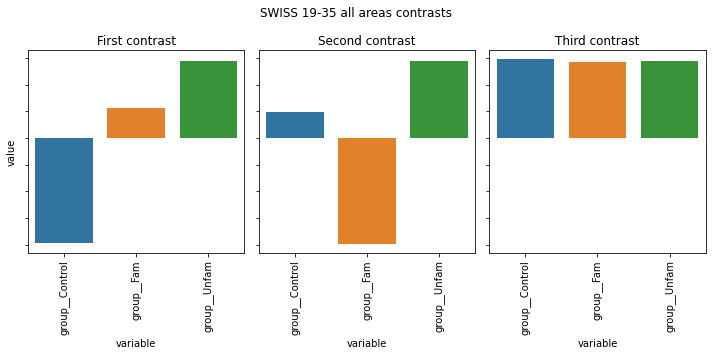

In [15]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
plt.subplots
upls.single_plot(df_data=swiss_contrasts, index=0, ax=axes[0])
upls.single_plot(df_data=swiss_contrasts, index=1, ax=axes[1])
upls.single_plot(df_data=swiss_contrasts, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[1].set(yticklabels=[])
axes[2].set_ylabel('')
axes[2].set(yticklabels=[])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
fig.suptitle('SWISS 19-35 all areas contrasts')
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35_pls_contrasts_all_areas.png')

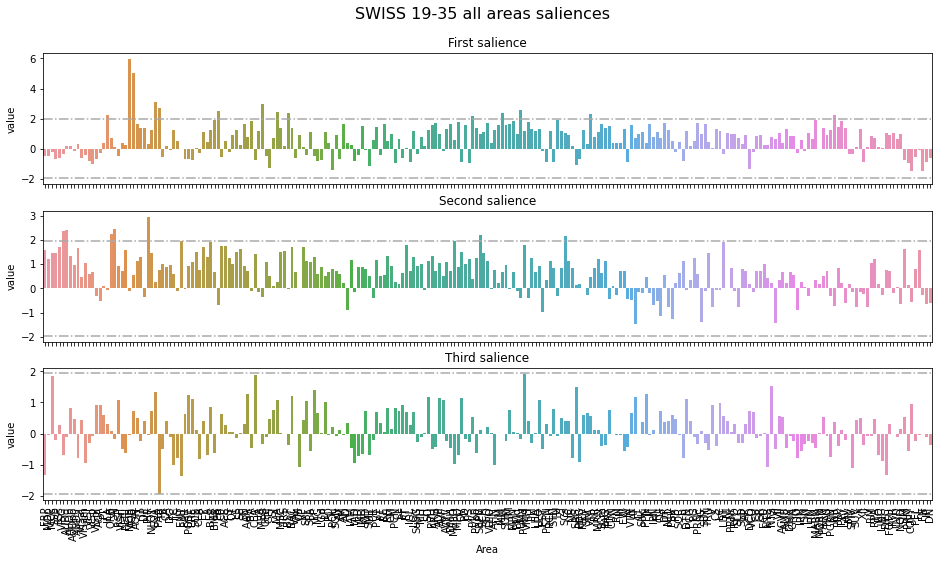

In [16]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=swiss_saliences, index=0, ax=axes[0])
upls.single_plot(df_data=swiss_saliences, index=1, ax=axes[1])
upls.single_plot(df_data=swiss_saliences, index=2, ax=axes[2])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
# plt.tight_layout()
fig.suptitle('SWISS 19-35 all areas saliences', fontsize=16)
plt.savefig('./results_pls/swiss_19-35_pls_saliences_all_areas.png')
plt.savefig('./results_pls/swiss_19-35_pls_saliences_all_areas.eps')

# Identify areas with significant salience contribution

In [17]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=swiss_saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)

In [18]:
pls_sig_areas

array(['Accessory olfactory bulb', 'Agranular insular area',
       'Bed nuclei of the stria terminalis', 'Cortical amygdalar area',
       'Dorsal auditory area', 'Infralimbic area',
       'Magnocellular nucleus', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Medial mammillary nucleus',
       'Nucleus of Roller', 'Orbital area',
       'Periventricular hypothalamic nucleus posterior part',
       'Piriform area', 'Piriform-amygdalar area',
       'Posterior amygdalar nucleus', 'Subparaventricular zone',
       'Superior colliculus sensory related',
       'Ventral premammillary nucleus', 'Ventral tegmental area',
       'Visceral area'], dtype='<U51')

# Apply PLS for all significant areas in ncells and energy

In [19]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'_energy_filt.csv')

In [20]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35_n_cells_filt.csv -o './results_pls/SWISS_19-35_filt'

2023-05-02 16:15:48 PC1QFRRQ __main__[406768] INFO reading data...
2023-05-02 16:15:49 PC1QFRRQ __main__[406768] INFO computing PLS...
2023-05-02 16:15:49 PC1QFRRQ __main__[406768] INFO PLS computed, now performing bootstrap...
2023-05-02 16:15:49 PC1QFRRQ __main__[406768] INFO saving output data...


In [21]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35_energy_filt.csv -o './results_pls/SWISS_19-35_filt'

2023-05-02 16:15:51 PC1QFRRQ __main__[406773] INFO reading data...
2023-05-02 16:15:51 PC1QFRRQ __main__[406773] INFO computing PLS...
2023-05-02 16:15:51 PC1QFRRQ __main__[406773] INFO PLS computed, now performing bootstrap...
2023-05-02 16:15:52 PC1QFRRQ __main__[406773] INFO saving output data...


In [22]:
swiss_contrasts_filt = pd.read_csv('./results_pls/SWISS_19-35_filt_contrasts.csv')
swiss_saliences_filt = pd.read_csv('./results_pls/SWISS_19-35_filt_saliences.csv')
swiss_contrasts_filt.columns = ['Control', 'Fam', 'Unfam']

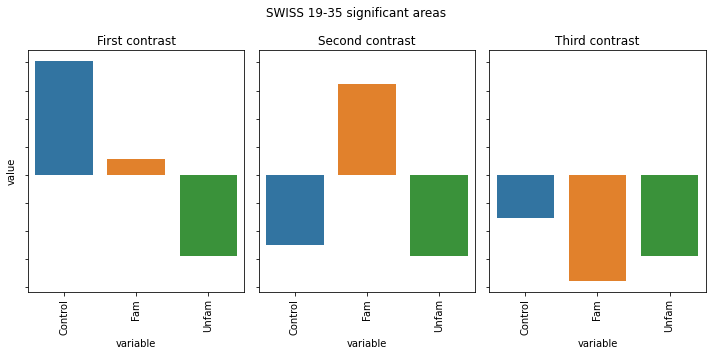

In [23]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.single_plot(df_data=swiss_contrasts_filt, index=0, ax=axes[0])
upls.single_plot(df_data=swiss_contrasts_filt, index=1, ax=axes[1])
upls.single_plot(df_data=swiss_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[1].set(yticklabels=[])
axes[2].set_ylabel('')
axes[2].set(yticklabels=[])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
fig.suptitle('SWISS 19-35 significant areas')
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35_pls_contrasts_sig_areas.png')

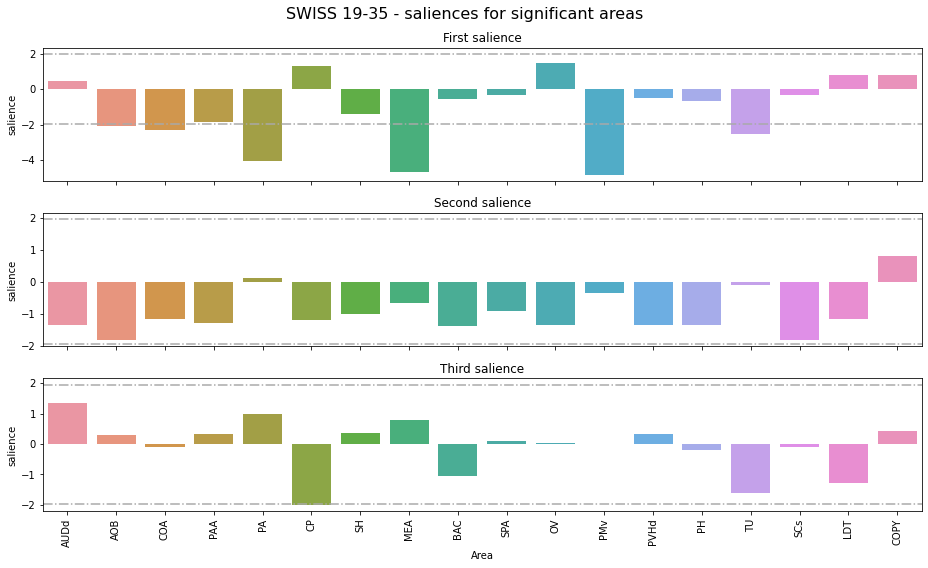

In [27]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=swiss_saliences_filt, index=0, ax=axes[0])
upls.single_plot(df_data=swiss_saliences_filt, index=1, ax=axes[1])
upls.single_plot(df_data=swiss_saliences_filt, index=2, ax=axes[2])
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
fig.suptitle('SWISS 19-35 - saliences for significant areas', fontsize=16)
for i in range(3):
    axes[i].set_ylabel('salience')
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35_pls_saliences_sig_areas.png')
plt.savefig('./results_pls/swiss_19-35_pls_saliences_sig_areas.eps')

# Identify areas with significant salience contribution

In [25]:
pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=swiss_saliences_filt, 
                                       threshold=1.96, 
                                       volumes=volumes)
pls_sig_areas_filt

array(['Accessory olfactory bulb', 'Caudoputamen',
       'Cortical amygdalar area', 'Medial amygdalar nucleus',
       'Posterior amygdalar nucleus', 'Tuberal nucleus',
       'Ventral premammillary nucleus'], dtype='<U29')